# 자동차 번호판 영상으로 부터 숫자 검출
---

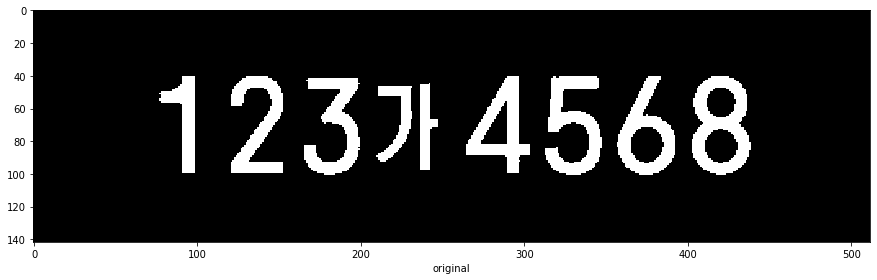

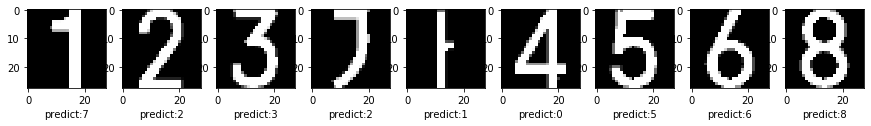

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# --------------------------------

from models.mnist_2_layers import model, checkpoint, input_shape

IMAGE_PATH = 'res/data/자동차_번호판_인식/자동차 번호판.jpeg'

# --------------------------------

def calc_padding(x, y, padding):
    x0, y0 = (x+padding,    y+padding)
    x1, y1 = (x+w-padding,  y+h-padding)
    return x0, y0, x1, y1

# --------------------------------
# 이미지 불러오기 & 이진화
# --------------------------------

frame = cv2.imread(IMAGE_PATH)

frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
ret, frame_thresh = cv2.threshold(frame_gray, 128, 255, cv2.THRESH_BINARY_INV)

# --------------------------------
# 패딩을 이용하여 문자영역만 남기고 테두리 제거
# --------------------------------

# 1. 빈 프레임 생성
frame_letters = np.zeros(frame_thresh.shape, dtype=np.uint8)

# 2. 외곽선 검출
contours, hierachy = cv2.findContours(frame_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
extern_cont = contours[0]

# 3. 테두리를 제외한 영역 잘라내기
x,y,w,h = cv2.boundingRect(extern_cont)
x0,y0,x1,y1 = calc_padding(x,y,5)
frame_letters[y0:y1, x0:x1] = frame_thresh[y0:y1, x0:x1]

# --------------------------------
# 문자 영역으로부터 문자 검출 (모델에 입력할 데이터 생성)
# --------------------------------
contours, hierachy = cv2.findContours(frame_letters, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 랜덤 순으로 검출된 문자를 번호판에서의 문자 순서로 정렬
contours = sorted(contours, key=lambda cont: cv2.boundingRect(cont)[0]) # 바운딩 박스의 x,y,w,h중 x를 기준으로 sort

x_predict = []

for cont in contours:
    if cv2.contourArea(cont) < 20 : continue

    x,y,w,h = cv2.boundingRect(cont)

    # 1. 한 문자만을 마스킹하는 이미지 생성
    mask = np.zeros(frame_letters.shape, dtype=np.uint8)
    cv2.drawContours(mask, [cont], 0, 255, -1)

    # 2. 해당 문자만을 잘라냄
    masked = cv2.bitwise_and(frame_letters,frame_letters, mask=mask)[y:y+h, x:x+w]

    # 3. 새로 생성한 정사각형 형태의 프레임에 중앙에 문자 삽입
    n = max([h,w])
                         
    dx, dy = 0, 0 # 잘라낸 숫자를 (dx,dy)만큼 평행이동하여, 중앙에 위치하도록 옮김.
    if (w > h): dy = (w-h)//2
    else:       dx = (h-w)//2
                                
    square_frame = np.zeros((n,n), dtype=np.uint8)
    square_frame[dy:dy+h, dx:dx+w] = masked

    # 4. 모델에 입력할 수 있는 형태가 되도록 데이터의 크기를 조정
    _x = cv2.resize(square_frame, (28,28))
    _x = _x.reshape(input_shape)

    x_predict.append(_x)

# --------------------------------
# 문자 영역으로부터 문자 검출
# --------------------------------
model.load_weights(checkpoint)

x_predict = np.array(x_predict)
y_predict = [np.where(p == max(p))[0][0] for p in model.predict(x_predict)]

# --------------------------------
# 결과 출력
# --------------------------------
n_of_contours = len(contours)

plt.figure(figsize=(15,10))
plt.xlabel('original')
plt.imshow(frame_letters, cmap='gray')

fig, axs = plt.subplots(1, n_of_contours, figsize=(15,9))
for i in range(n_of_contours):
    axs[i].imshow(np.squeeze(x_predict[i]), cmap='gray')
    axs[i].set_xlabel('predict:'+str(y_predict[i]))

plt.show()

# Tesseract를 이용한 문자 검출
---

## Tesseract 설치과정

```shell
brew install tesseract
brew install tesseract-lang
```

* 테서렉트 설치 : https://tesseract-ocr.github.io/tessdoc/Home.html
    * https://github.com/tesseract-ocr/tesseract

## Matplotlib에서 한글 출력 오류 문제

한글 사용이 가능한 폰트를 따로 지정해주어야함.

In [58]:
# http://corazzon.github.io/matplotlib_font_setting

import matplotlib as mpl
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_list_mac = fm.OSXInstalledFonts()

search_keyword = 'Neo'
searched_fonts = [(f.name, f.fname) for f in fm.fontManager.ttflist if search_keyword in f.name]
print(searched_fonts)

[('Apple SD Gothic Neo', '/System/Library/Fonts/AppleSDGothicNeo.ttc')]


## Tesseract를 이용하여 번호판 문자 인식

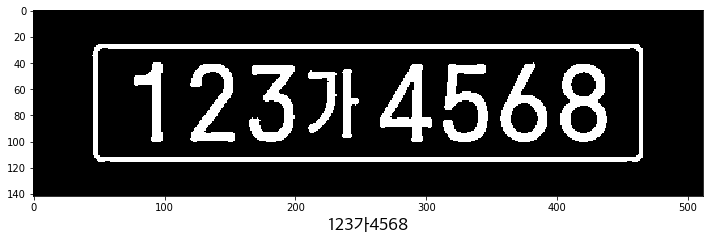

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pytesseract

IMAGE_PATH = 'res/data/자동차_번호판_인식/자동차 번호판.jpeg'
KOREAN_FONT_PATH = '/System/Library/Fonts/AppleSDGothicNeo.ttc'

# --------------------------------
# 한글 결과를 출력하기 위한 폰트 설정
# --------------------------------

import matplotlib.font_manager as fm
font = fm.FontProperties(fname=KOREAN_FONT_PATH, size=18)

# --------------------------------
# 이미지 전처리
# --------------------------------
frame = cv2.imread(IMAGE_PATH)

frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame_blurred = cv2.GaussianBlur(frame_gray, ksize=(5, 5), sigmaX=0)
frame_thresh = cv2.adaptiveThreshold(
    frame_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9)
frame_morphed = cv2.morphologyEx(
    frame_thresh,
    cv2.MORPH_OPEN,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

# --------------------------------
# 결과 출력
# --------------------------------
image = frame_morphed
letters = pytesseract.image_to_string(image, lang='kor')

plt.figure(figsize=(12,10))
plt.xlabel(letters, fontproperties=font)
plt.imshow(image, cmap='gray')

# 차량 이미지로부터 번호판 문자 추출
---

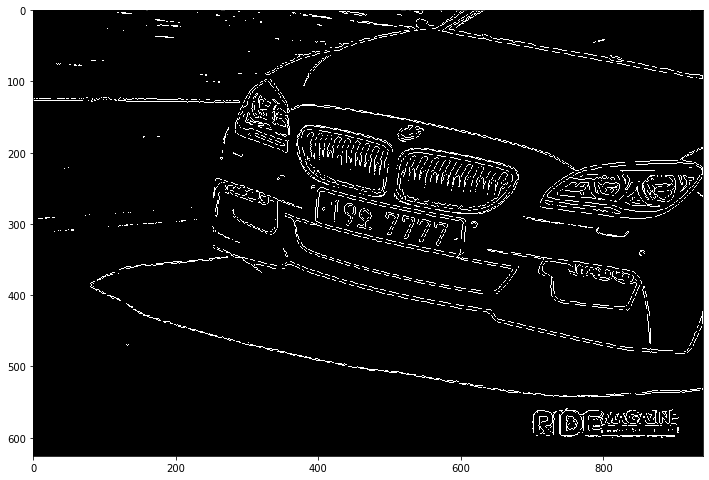

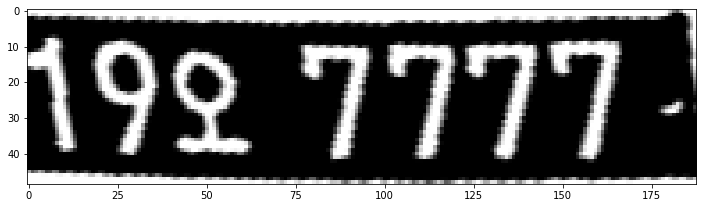

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract


IMAGE_PATH = 'res/data/자동차_번호판_인식/1.jpg'

# --------------------------------

img_ori = cv2.imread(IMAGE_PATH)

height, width, channel = img_ori.shape

# --------------------------------

gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

# --------------------------------

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

# --------------------------------

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

# --------------------------------

contours = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE)[-2]

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# --------------------------------

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

# --------------------------------

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
    
# --------------------------------

MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)


plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# --------------------------------

PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# --------------------------------

longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    cv2.imwrite('out/bunho.png', img_result)

    chars = pytesseract.image_to_string(img_result, lang='kor')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)

# --------------------------------
# --------------------------------
# --------------------------------




In [49]:

import cv2
import pytesseract
from matplotlib import pyplot as plt

fname = 'out/bunho.png'
# fname = 'res/data/자동차_번호판_인식/자동차 번호판.jpeg'

frame = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
ksize = (3,3)

frame = cv2.morphologyEx(frame,cv2.MORPH_OPEN, ksize, iterations=3)
frame = cv2.erode(frame, ksize, iterations=3)



# 랜덤 순으로 검출된 문자를 번호판에서의 문자 순서로 정렬
contours = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

contours = sorted(contours, key=lambda cont: cv2.boundingRect(cont)[0]) # 바운딩 박스의 x,y,w,h중 x를 기준으로 sort

x_predict = []

for cont in contours:
    if cv2.contourArea(cont) < 20 : continue

    x,y,w,h = cv2.boundingRect(cont)

    # 1. 한 문자만을 마스킹하는 이미지 생성
    mask = np.zeros(frame.shape, dtype=np.uint8)
    cv2.drawContours(mask, [cont], 0, 255, -1)

    # 2. 해당 문자만을 잘라냄
    masked = cv2.bitwise_and(frame,frame, mask=mask)[y:y+h, x:x+w]

    # 3. 새로 생성한 정사각형 형태의 프레임에 중앙에 문자 삽입
    n = max([h,w])
                         
    dx, dy = 0, 0 # 잘라낸 숫자를 (dx,dy)만큼 평행이동하여, 중앙에 위치하도록 옮김.
    if (w > h): dy = (w-h)//2
    else:       dx = (h-w)//2
                                
    square_frame = np.zeros((n,n), dtype=np.uint8)
    square_frame[dy:dy+h, dx:dx+w] = masked

    paddings = 8
    pad = paddings//2
    dilated_square_frame = np.zeros((n+paddings,n+paddings), dtype=np.uint8)
    dilated_square_frame[pad:-pad, pad:-pad] = square_frame

    # 4. 모델에 입력할 수 있는 형태가 되도록 데이터의 크기를 조정
    _x = cv2.resize(dilated_square_frame, (48,48))

    x_predict.append(_x)


result = ''

fig, axs = plt.subplots(1, len(x_predict), figsize=(12,9))

for i in range(len(x_predict)):
    x = x_predict[i]

    char = pytesseract.image_to_string(x, lang='kor')
    result += char
    axs[i].imshow(x, cmap='gray')
    axs[i].set_xlabel(char)

print(result)
plt.figure(figsize=(12,9))
plt.imshow(frame)

NameError: name 'figsize' is not defined